# Flax MNIST Example

<a href="https://colab.research.google.com/github/google/flax/blob/master/examples/mnist/mnist.ipynb" ><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Demonstration notebook for
https://github.com/google/flax/tree/master/examples/mnist

If you're looking for an **annotated** version of Flax MNIST
https://colab.research.google.com/github/google/flax/blob/master/docs/notebooks/annotated_mnist_example._ipynb

The **Flax Notebook Workflow**:

1. Run the entire notebook end-to-end and check out the outputs.
   - This will open Python files in the right-hand editor!
   - You'll be able to interactively explore metrics in TensorBoard.
2. Change `config` and train for different hyperparameters. Check out the
   updated TensorBoard plots.
3. Update the code in `train.py`. Thanks to `%autoreload`, any changes you
   make in the file will automatically appear in the notebook. Some ideas to
   get you started:
   - Change the model.
   - Log some per-batch metrics during training.
   - Add new hyperparameters to `configs/default.py` and use them in
     `train.py`.
4. At any time, feel free to paste code from `train.py` into the notebook
   and modify it directly there!

## Setup

In [ ]:
# Install ml-collections & latest Flax version from Github.
!pip install -q ml-collections git+https://github.com/google/flax

     |████████████████████████████████| 92kB 2.5MB/s 


In [ ]:
example_directory = 'examples/mnist'
editor_relpaths = ('configs/default.py', 'train.py')

In [ ]:
# (If you run this code in Jupyter[lab], then you're already in the
#  example directory and nothing needs to be done.)

#@markdown **Fetch newest Flax, copy example code**
#@markdown
#@markdown **If you select no** below, then the files will be stored on the
#@markdown *ephemeral* Colab VM. **After some time of inactivity, this VM will
#@markdown be restarted an any changes are lost**.
#@markdown
#@markdown **If you select yes** below, then you will be asked for your
#@markdown credentials to mount your personal Google Drive. In this case, all
#@markdown changes you make will be *persisted*, and even if you re-run the
#@markdown Colab later on, the files will still be the same (you can of course
#@markdown remove directories inside your Drive's `flax/` root if you want to
#@markdown manually revert these files).

if 'google.colab' in str(get_ipython()):
  import os
  os.chdir('/content')
  # Download Flax repo from Github.
  if not os.path.isdir('flaxrepo'):
    !git clone --depth=1 https://github.com/google/flax flaxrepo
  # Copy example files & change directory.
  mount_gdrive = 'no' #@param ['yes', 'no']
  if mount_gdrive == 'yes':
    DISCLAIMER = 'Note : Editing in your Google Drive, changes will persist.'
    from google.colab import drive
    drive.mount('/content/gdrive')
    example_root_path = f'/content/gdrive/My Drive/flax/{example_directory}'
  else:
    DISCLAIMER = 'WARNING : Editing in VM - changes lost after reboot!!'
    example_root_path = f'/content/{example_directory}'
    from IPython import display
    display.display(display.HTML(
        f'<h1 style="color:red;" class="blink">{DISCLAIMER}</h1>'))
  if not os.path.isdir(example_root_path):
    os.makedirs(example_root_path)
    !cp -r flaxrepo/$example_directory/* "$example_root_path"
  os.chdir(example_root_path)
  from google.colab import files
  for relpath in editor_relpaths:
    s = open(f'{example_root_path}/{relpath}').read()
    open(f'{example_root_path}/{relpath}', 'w').write(
        f'## {DISCLAIMER}\n' + '#' * (len(DISCLAIMER) + 3) + '\n\n' + s)
    files.view(f'{example_root_path}/{relpath}')

In [ ]:
# Note : In Colab, above cell changed the working direcoty.
!pwd

/content/examples/mnist


## Imports / Helpers

In [ ]:
from absl import logging
import flax
import jax.numpy as jnp
from matplotlib import pyplot as plt
import numpy as np
import tensorflow_datasets as tfds

logging.set_verbosity(logging.INFO)

In [ ]:
# Helper functions for images.

def show_img(img, ax=None, title=None):
  """Shows a single image."""
  if ax is None:
    ax = plt.gca()
  ax.imshow(img[..., 0], cmap='gray')
  ax.set_xticks([])
  ax.set_yticks([])
  if title:
    ax.set_title(title)

def show_img_grid(imgs, titles):
  """Shows a grid of images."""
  n = int(np.ceil(len(imgs)**.5))
  _, axs = plt.subplots(n, n, figsize=(3 * n, 3 * n))
  for i, (img, title) in enumerate(zip(imgs, titles)):
    show_img(img, axs[i // n][i % n], title)

In [ ]:
# Local imports from current directory - auto reload.
# Any changes you make to train.py will appear automatically.
%load_ext autoreload
%autoreload 2
import train
from configs import default as config_lib
config = config_lib.get_config()

## Dataset

In [ ]:
# Get datasets as dict of JAX arrays.
train_ds, test_ds = train.get_datasets()

INFO:absl:Load pre-computed datasetinfo (eg: splits) from bucket.
INFO:absl:Loading info from GCS for mnist/3.0.0
INFO:absl:Field info.location from disk and from code do not match. Keeping the one from code.
INFO:absl:Generating dataset mnist (/root/tensorflow_datasets/mnist/3.0.0)
local data directory. If you'd instead prefer to read directly from our public
GCS bucket (recommended if you're running on GCP), you can instead set
data_dir=gs://tfds-data/datasets.



INFO:absl:Field info.location from disk and from code do not match. Keeping the one from code.
INFO:absl:Constructing tf.data.Dataset for split train, from /root/tensorflow_datasets/mnist/3.0.0




Dataset mnist downloaded and prepared to /root/tensorflow_datasets/mnist/3.0.0. Subsequent calls will reuse this data.


INFO:absl:Constructing tf.data.Dataset for split test, from /root/tensorflow_datasets/mnist/3.0.0


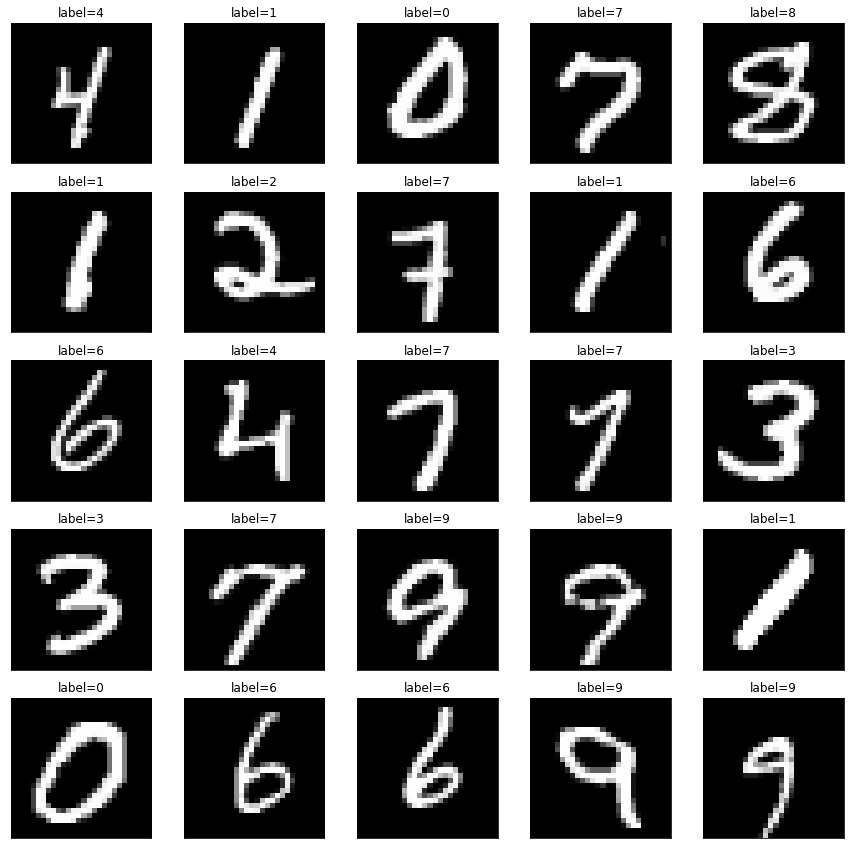

In [ ]:
show_img_grid(
    [train_ds['image'][idx] for idx in range(25)],
    [f'label={train_ds["label"][idx]}' for idx in range(25)],
)

## Training

In [ ]:
# Get a live update during training - use the "refresh" button!
# (In Jupyter[lab] start "tensorbaord" in the local directory instead.)
if 'google.colab' in str(get_ipython()):
  %load_ext tensorboard
  %tensorboard --logdir=.

In [ ]:
# 3x 3 epochs trains in ~1 minute in the GPU Colab...

# We don't use TPUs in this Colab because we do not distribute our
# training using pmap() - if you're looking for an example using TPUs
# checkout below Colab:
# https://colab.research.google.com/github/google/flax/blob/master/examples/imagenet/imagenet.ipynb

config.num_epochs = 3
models = {}
for momentum in (0.8, 0.9, 0.95):
  name = f'momentum={momentum}'
  config.momentum = momentum
  optimizer = train.train_and_evaluate(config, workdir=f'./models/{name}')
  models[name] = optimizer.target

INFO:absl:Overwrite dataset info from restored data version.
INFO:absl:Field info.location from disk and from code do not match. Keeping the one from code.
INFO:absl:Reusing dataset mnist (/root/tensorflow_datasets/mnist/3.0.0)
INFO:absl:Constructing tf.data.Dataset for split train, from /root/tensorflow_datasets/mnist/3.0.0
INFO:absl:Constructing tf.data.Dataset for split test, from /root/tensorflow_datasets/mnist/3.0.0
INFO:absl:train epoch: 1, loss: 0.2353, accuracy: 92.96
INFO:absl:eval epoch: 1, loss: 0.0587, accuracy: 97.94
INFO:absl:train epoch: 2, loss: 0.0587, accuracy: 98.16
INFO:absl:eval epoch: 2, loss: 0.0576, accuracy: 98.09
INFO:absl:train epoch: 3, loss: 0.0422, accuracy: 98.69
INFO:absl:eval epoch: 3, loss: 0.0345, accuracy: 98.83
INFO:absl:Overwrite dataset info from restored data version.
INFO:absl:Field info.location from disk and from code do not match. Keeping the one from code.
INFO:absl:Reusing dataset mnist (/root/tensorflow_datasets/mnist/3.0.0)
INFO:absl:Cons

In [ ]:
if 'google.colab' in str(get_ipython()):
  #@markdown You can upload the training results directly to https://tensorbaord.dev
  #@markdown
  #@markdown Note that everbody with the link will be able to see the data.
  upload_data = 'no' #@param ['yes', 'no']
  if upload_data == 'yes':
    !tensorboard dev upload --one_shot --logdir ./models --name 'Flax examples/mnist'

## Inference

In [ ]:
# Find all mistakes in testset.
logits = train.CNN().apply({'params': optimizer.target}, test_ds['image'])
error_idxs, = jnp.where(test_ds['label'] != logits.argmax(axis=1))
len(error_idxs) / len(logits)

0.0112

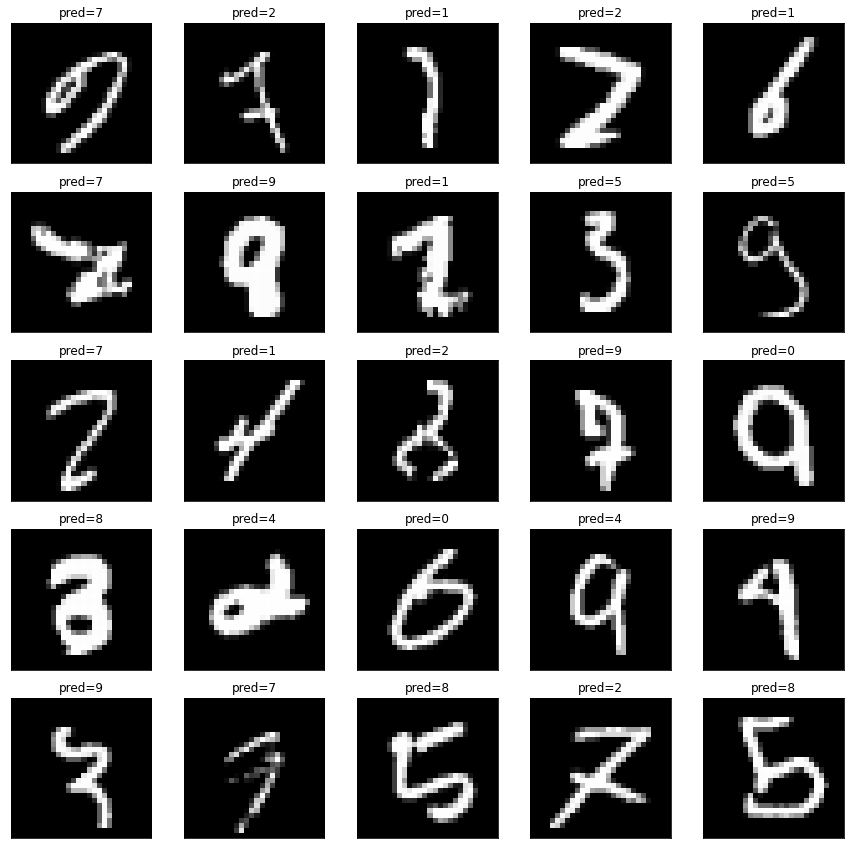

In [ ]:
# Show some of them.
show_img_grid(
    [test_ds['image'][idx] for idx in error_idxs[:25]],
    [f'pred={logits[idx].argmax()}' for idx in error_idxs[:25]],
)